In [ ]:
import matplotlib.image as mpimg
import seaborn as sns
from PIL import Image
from IPython.display import Image, display
import os

from sklearn.metrics import confusion_matrix
from sklearn.datasets import load_files
from sklearn.model_selection import train_test_split

import tensorflow_hub as hub
from keras.utils.np_utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.applications import ResNet50, VGG16, VGG19, MobileNetV2
from tensorflow.keras.applications.resnet50 import preprocess_input as prepro_res50
from tensorflow.keras.applications.vgg19 import preprocess_input as prepro_vgg19
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, GlobalAveragePooling2D, BatchNormalization, Dropout, MaxPool2D, MaxPooling2D

In [ ]:
# load the backend
from keras import backend as K

# prevent Tensorflow memory leakage
K.clear_session()

In [ ]:
path_data = '/content/drive/MyDrive/Colab Notebooks/my_projects/flower_recog/data/'
print(os.listdir(path_data))

['toad_lily', 'Sunflower', 'scilia', 'orris_root', 'lilly_of_the_valley', 'flowering_dogwood']


In [ ]:
from os.path import join

img_folders = [join(path_data, folder) for folder in os.listdir(path_data)]
list(img_folders)

['/content/drive/MyDrive/Colab Notebooks/my_projects/flower_recog/data/toad_lily',
 '/content/drive/MyDrive/Colab Notebooks/my_projects/flower_recog/data/Sunflower',
 '/content/drive/MyDrive/Colab Notebooks/my_projects/flower_recog/data/scilia',
 '/content/drive/MyDrive/Colab Notebooks/my_projects/flower_recog/data/orris_root',
 '/content/drive/MyDrive/Colab Notebooks/my_projects/flower_recog/data/lilly_of_the_valley',
 '/content/drive/MyDrive/Colab Notebooks/my_projects/flower_recog/data/flowering_dogwood']

In [ ]:
import numpy as np
data_dir = '/content/drive/MyDrive/Colab Notebooks/my_projects/flower_recog/data/'

data = load_files(data_dir, random_state=28, shuffle=True)
X = np.array(data['filenames'])    # files location of each flower
y = np.array(data['target'])       # target label of each flower
labels = np.array(data['target_names'])

# remove eventual .pyc or .py files
pyc_file = (np.where(file==X) for file in X if file.endswith(('.pyc','.py')))
for pos in pyc_file:
    X = np.delete(X, pos)
    y = np.delete(y, pos)
    
print(f'Data files - {X}')
print(f'Target labels - {y}')   # numbers are corresponding to class label, 
                               # we have to change them to a vector of 5 elements
print(f'Name labels - {labels}')
print(f'Number of training files : {X.shape[0]}')

In [ ]:
import pandas as pd

# Flower species number
df = pd.DataFrame({'species': y})
print(df.shape)
df.head()

(480, 1)


,species
0,0
1,4
2,1
3,2
4,0


In [ ]:
# associate names to species number
df['flower'] = df['species'].astype('category')
df['flower'].cat.categories = labels
df.head()

,species,flower
0,0,Sunflower
1,4,scilia
2,1,flowering_dogwood
3,2,lilly_of_the_valley
4,0,Sunflower


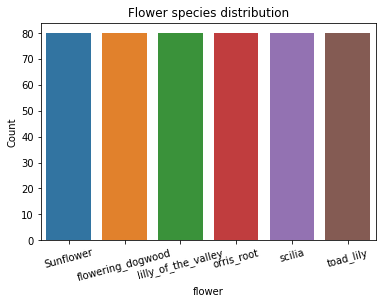

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax = sns.countplot(x="flower", data=df)
ax.set(ylabel='Count', title='Flower species distribution')
ax.tick_params(axis='x', rotation=15)

In [ ]:
image_size = 224     # standard value for Transfer learning usecase (MobileNet, ResNet50, VGG16, VGG19)

def read_and_prep_images(img_paths, img_height=image_size, img_width=image_size):
    imgs = [load_img(img_path, target_size=(img_height, img_width)) for img_path in img_paths]   # load image
    img_array = np.array([img_to_array(img) for img in imgs])   # image to array 
    return(img_array)

X = np.array(read_and_prep_images(X))
print(X.shape)  # (4323, 224, 224, 3) = (num_images, height_size, width_size, depth=RGB)

(480, 224, 224, 3)


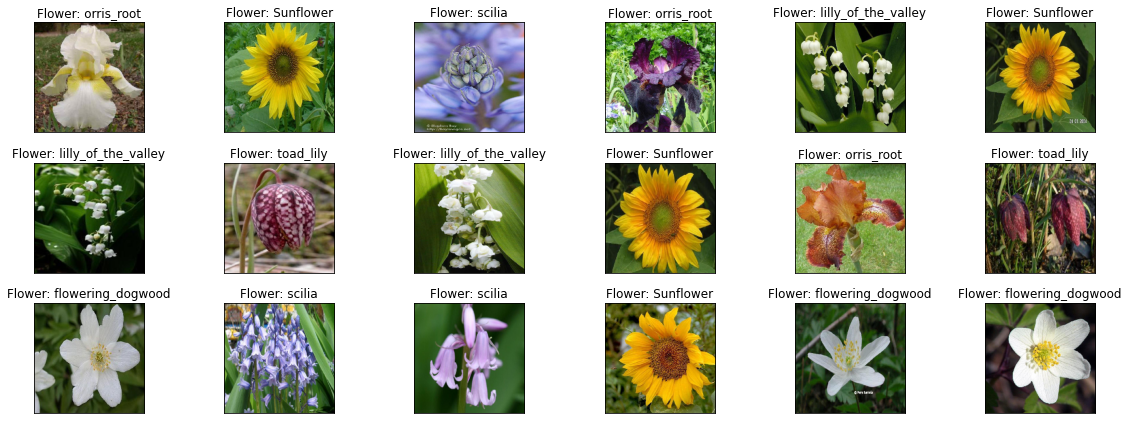

In [ ]:
N = 18  # flowers to display
fig, axes = plt.subplots(3, 6, figsize=(16,6))
for ax, j in zip(axes.flat, np.random.randint(0, len(X), N)):    
    ax.imshow(X[j].astype(np.uint8))
    ax.set(title=f'Flower: {labels[y[j]]}', xticks=[], yticks=[])
fig.tight_layout()

In [ ]:
num_classes = len(np.unique(y))
print(f'Number of classes: {num_classes} --> {labels}')

Number of classes: 6 --> ['Sunflower' 'flowering_dogwood' 'lilly_of_the_valley' 'orris_root'
 'scilia' 'toad_lily']


In [ ]:
y = to_categorical(y, num_classes)
print(y.shape)

(480, 6)


In [ ]:
#train, validation and test from the train dataset
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, shuffle=True, 
                                                test_size=0.25, random_state=28)

Xval, Xtest, yval, ytest = train_test_split(Xtest, ytest, test_size=0.5,
                                            shuffle=True, random_state=28)
print(f'Train dataset: {Xtrain.shape[0]}')
print(f'Validation dataset: {Xval.shape[0]}')
print(f'Test dataset: {Xtest.shape[0]}')

Train dataset: 360
Validation dataset: 60
Test dataset: 60


In [ ]:
del X

In [ ]:
del y

In [ ]:
img_shape = (image_size, image_size, 3)

print('Loading MobileNetV2 ...')
base_model = MobileNetV2(input_shape=img_shape,
                   include_top=False,
                   weights='imagenet')
print('MobileNetV2 loaded')

base_model.trainable = False

Loading MobileNetV2 ...
9412608/9406464 [==============================] - 0s 0us/step
MobileNetV2 loaded


In [ ]:
base_model.output_shape

(None, 7, 7, 1280)

In [ ]:
model = Sequential([base_model,
                    GlobalAveragePooling2D(), 
                    Dense(num_classes, activation='softmax')
                   ])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 6)                 7686      
Total params: 2,265,670
Trainable params: 7,686
Non-trainable params: 2,257,984
_________________________________________________________________


In [ ]:
# callbacks 
weight_path = '{}_best_weights.hdf5'.format('flower')
checkpointer = ModelCheckpoint(weight_path,
                               monitor='val_accuracy',
                               verbose=1, 
                               save_best_only=True,
                               mode='auto',
                               save_weights_only=True)

# set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.7, 
                                            min_lr=0.00001)
    
# early stop if not improvement of accuracy after 5 epochs
early = EarlyStopping(patience=6, 
                      verbose=1) 
    
callbacks = [checkpointer, learning_rate_reduction] #, early]

# Optimizer
opt = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
    
# Compilation
model.compile(optimizer=opt, 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
image_size = 224
batch_size = 32
path = '/content/drive/MyDrive/Colab Notebooks/my_projects/flower_recog/data/'

#train_gen = train_aug.flow(Xtrain, ytrain, batch_size=batch_size)
# The validation data must not have data augmentation
#valid_gen = valid_no_aug.flow(Xval, yval, batch_size=batch_size)

train_datagen = ImageDataGenerator(
        rescale=1./255,           # rescale pixel values [0,255] to [0,1]
        horizontal_flip=True,     # random horizontal flip
        width_shift_range=0.2,    # random shift images horizontally (fraction of total width)
        height_shift_range=0.2,   # random shift images vertically (fraction of total height)
        zoom_range=0.2)           # random zoom image
        #rotation_range=20,       # random rotation
        #shear_range=0.2)         # shear transfo
        #validation_split=0.2)    # splitting train / test datasets

test_datagen = ImageDataGenerator(
        rescale=1./255)
        #validation_split=0.2)

train_gen = train_datagen.flow(
        Xtrain, ytrain, 
        batch_size=batch_size,
        shuffle=False)              # already applied

valid_gen = test_datagen.flow(
        Xval, yval,
        batch_size=batch_size,
        shuffle=False)

In [ ]:
batch_size = 32
epochs_0 = 40
steps_per_epoch = len(train_gen.x) // train_gen.batch_size
validation_steps = len(valid_gen.x) // valid_gen.batch_size

history = model.fit(
    train_gen,
    steps_per_epoch=len(Xtrain) // batch_size,   # or batch_size=32
    epochs=epochs_0 ,
    validation_data=valid_gen,
    validation_steps=len(Xval) // batch_size,
    callbacks=callbacks)

Epoch 1/40
11/11 [==============================] - 16s 1s/step - loss: 1.2478 - accuracy: 0.5244 - val_loss: 0.8984 - val_accuracy: 0.7812

Epoch 00001: val_accuracy improved from -inf to 0.78125, saving model to flower_best_weights.hdf5
Epoch 2/40
11/11 [==============================] - 12s 1s/step - loss: 0.6036 - accuracy: 0.8567 - val_loss: 0.6141 - val_accuracy: 0.8125

Epoch 00002: val_accuracy improved from 0.78125 to 0.81250, saving model to flower_best_weights.hdf5
Epoch 3/40
11/11 [==============================] - 12s 1s/step - loss: 0.4234 - accuracy: 0.8994 - val_loss: 0.4482 - val_accuracy: 0.8438

Epoch 00003: val_accuracy improved from 0.81250 to 0.84375, saving model to flower_best_weights.hdf5
Epoch 4/40
11/11 [==============================] - 12s 1s/step - loss: 0.3295 - accuracy: 0.9233 - val_loss: 0.3950 - val_accuracy: 0.8438

Epoch 00004: val_accuracy did not improve from 0.84375
Epoch 5/40
11/11 [==============================] - 12s 1s/step - loss: 0.2413 - 

In [ ]:
def plot_history(history, loss_max=5):
    """
    Check loss and accuracy evolution.
    """
    
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(14, 4))
    ax1.plot(acc, label='Training')
    ax1.plot(val_acc, label='Validation')
    ax1.legend(loc='lower right')
    ax1.set(ylabel='Accuracy', title='Training - Validation Accuracy', 
            ylim=([min(plt.ylim()),1]))

    ax2.plot(loss, label='Training')
    ax2.plot(val_loss, label='Validation')
    ax2.legend(loc='upper right')
    ax2.set(ylabel='Loss (cross entropy)', xlabel='epochs',
           title='Training - Validation Loss', ylim=([0, loss_max]))
    plt.show()

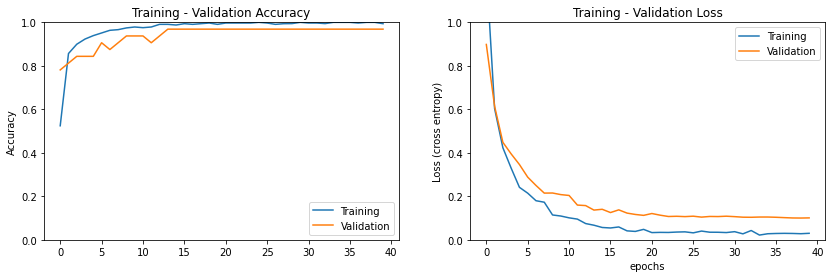

In [ ]:
plot_history(history, loss_max=1)

In [ ]:
datagen = ImageDataGenerator(
        rescale=1./255)

eval_datagen = datagen.flow(
        Xtest, ytest,
        batch_size=batch_size,
        shuffle=False)      # since shuffle was already during splitting into train, valid, test

# Evaluation on the test dataset
loss, acc = model.evaluate_generator(eval_datagen, verbose=0)
print(f'Test loss: {loss:.2f}')
print(f'Test accuracy: {acc*100:.2f}%')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1973: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


Test loss: 0.07
Test accuracy: 100.00%


In [ ]:
base_model.trainable = True

# Let's take a look to see how many layers are in the base model
print(f'Number of layers in the base model: {len(base_model.layers)}')

Number of layers in the base model: 154


In [ ]:
# Fine-tune from this layer onwards
fine_tuning = 100

# Freeze all the layers before fine_tuned_ind
for layer in base_model.layers[:fine_tuning]:
    layer.trainable =  False

In [ ]:
# Load best weights
# model.load_weights(weight_path)

# Finer learning rate now
opt = RMSprop(lr=0.0001, rho=0.9, epsilon=1e-08, decay=0.0)
    
# Compilation
model.compile(optimizer=opt, 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 6)                 7686      
Total params: 2,265,670
Trainable params: 1,869,126
Non-trainable params: 396,544
_________________________________________________________________


In [ ]:
fine_tuned_epochs = 40
total_epochs = epochs_0 + fine_tuned_epochs

history_fined = model.fit_generator(
    train_gen,
    steps_per_epoch=len(Xtrain) // batch_size,   # or batch_size=32
    epochs=total_epochs,
    initial_epoch=history.epoch[-1],
    validation_data=valid_gen,
    validation_steps=len(Xval) // batch_size,
    callbacks=callbacks)

In [ ]:
def plot_history_fined(history, history_fined, initial_epochs=epochs_0, loss_max=1):
    """
    Check loss and accuracy evolution after fine tuning
    """
    
    acc = history.history['accuracy'][:epochs_0]
    acc += history_fined.history['accuracy']
    val_acc = history.history['val_accuracy'][:epochs_0]
    val_acc += history_fined.history['val_accuracy']
    
    loss = history.history['loss'][:epochs_0]
    loss += history_fined.history['loss']
    val_loss = history.history['val_loss'][:epochs_0]
    val_loss += history_fined.history['val_loss']
  
    
    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(14, 4))
    ax1.plot(acc, label='Training')
    ax1.plot(val_acc, label='Validation')
    ax1.plot([initial_epochs-1,initial_epochs-1],
              plt.ylim(), label='fine-tuning', ls='--')
    ax1.legend(loc='lower right')
    ax1.set(ylabel='Accuracy', title='Training - Validation Accuracy', 
            ylim=([0.4,1.005]))

    ax2.plot(loss, label='Training')
    ax2.plot(val_loss, label='Validation')
    ax2.plot([initial_epochs-1,initial_epochs-1],
             [0,1] , label='fine-tuning', ls='--')
    ax2.legend(loc='upper right')
    ax2.set(ylabel='Loss (cross entropy)', xlabel='epochs',
           title='Training - Validation Loss', ylim=([0, loss_max]))
    plt.show()

In [ ]:
plot_history_fined(history, history_fined)

In [ ]:
# Evaluation on the test dataset
loss, acc = model.evaluate_generator(eval_datagen, verbose=0)
print(f'Test loss: {loss:.2f}')
print(f'Test accuracy: {acc*100:.2f}%')

In [ ]:
import seaborn as sns
from sklearn import metrics

pred = model.predict(eval_datagen, verbose=1)

# get most likely class
y_pred = pred.argmax(axis=1)
y_true = ytest.argmax(axis=1)

print(metrics.classification_report(y_true, y_pred))

# confusion matrix
mat = metrics.confusion_matrix(y_true, y_pred)
df_mat = pd.DataFrame(mat, index=labels, columns=labels)
plt.figure(figsize=(8,6))
sns.heatmap(df_mat, annot=True, fmt='d', cmap=plt.cm.Reds)
#plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [ ]:
N = 20  # flowers to display
fig, axes = plt.subplots(4, 5, figsize=(20,12))
for i, ax in enumerate(axes.flat):
    ax.imshow(Xtest[i].astype(np.uint8))
    ax.set(xticks=[], yticks=[])
    true = y_true[i]
    prediction = y_pred[i]   
    ax.set_xlabel(f'Predict: {labels[prediction]}\n True: {labels[true]}', 
                  color='black' if true == prediction else 'red')

#fig.tight_layout()
fig.suptitle('Predicted flowers; Incorrect Labels in Red', size=14)